In [1]:
from __future__ import print_function, division

In [2]:
#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

If you are new to this course and want more instructions on how to set up environement and all the libs (docker / windows / gpu / blas / etc.), you could read [vital instructions here](https://github.com/yandexdataschool/Practical_RL/issues/1#issue-202648393). 

Please make sure that your have bleeding edge versions of Theano, Lasagne and Agentnet.

# General purpose libs import

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from timeit import default_timer as timer

from IPython.core import  display

In [4]:
# if you have  GPU uncomment the line below 
# %env THEANO_FLAGS=device=gpu0, floatX=float32

Universal collection of a gentleman:

In [5]:
import gym

from agentnet.agent import Agent
from agentnet.experiments.openai_gym.wrappers import PreprocessImage
from agentnet.memory import WindowAugmentation, LSTMCell, GRUCell
from agentnet.target_network import TargetNetwork
from agentnet.resolver import EpsilonGreedyResolver, ProbabilisticResolver
from agentnet.experiments.openai_gym.pool import EnvPool
from agentnet.learning import qlearning

import theano
import theano.tensor as T 

import lasagne
from lasagne.layers import DenseLayer, Conv2DLayer, InputLayer, NonlinearityLayer
from lasagne.layers import batch_norm, get_all_params, get_output, reshape, concat, dropout
from lasagne.nonlinearities import rectify, leaky_rectify, elu, tanh, softmax

# Helper function definitions

Downsample image, and crop it, showing only the most useful part of image. 

In [6]:
def make_env():
    env = gym.make("KungFuMaster-v0")
    env = PreprocessImage(env, height=64, width=64, grayscale=True, crop=lambda img: img[60:-30, 7:] )
    return env 

Function for tracking performance while training 

In [7]:
def eval_and_plot(rewards, epoch_counter, pool, target_score, th_times, loop_times):
    rewards[epoch_counter] = np.mean(pool.evaluate(n_games=N_EVAL_GAMES, record_video=False, verbose=False))
    info_string = "Time (DL/All) {:.1f}/{:.1f}  epoch={}, mean_score={:.2f}"
    info_string = info_string.format(np.mean(th_times), np.mean(loop_times), 
                                     epoch_counter, np.mean(rewards[epoch_counter]))
    plt.figure(figsize=(8, 5))
    plt.plot(*zip(*sorted(rewards.items(), key=lambda t: t[0])))
    plt.grid()
    plt.ylabel("Mean reward over evaluation games")
    plt.title(info_string)
    plt.show()
    display.clear_output(wait=True)

# Experiment setup
Here we basically just load the game and check that it works

In [8]:
env = gym.make('KungFuMaster-v0')

[2017-11-10 05:33:47,174] Making new env: KungFuMaster-v0


In [9]:
print(env.env.get_action_meanings())

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


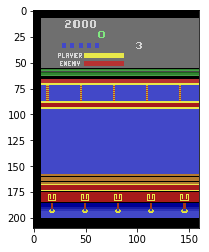

In [10]:
plt.imshow(env.reset())

[2017-11-10 05:33:47,676] Making new env: KungFuMaster-v0


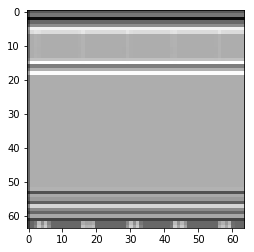

In [11]:
env = make_env()
plt.imshow(np.squeeze(env.reset()), interpolation='none', cmap='gray')

# Global constants definition

All hyperparameters (except number of layers and neurons) are declared here as upper case letters along with global varaibles.

In [12]:
N_ACTIONS = env.action_space.n
OBS_SHAPE = env.observation_space.shape 
OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH = OBS_SHAPE

# These 4 constanst were shown to lead to nearly state of the art on kung-fu master game
N_SIMULTANEOUS_GAMES = 8  # this is also known as number of agents in exp_replay_pool
SEQ_LENGTH = 30

EVAL_EVERY_N_ITER = 100
N_EVAL_GAMES = 2

N_FRAMES_IN_BUFFER = 4 # number of consequent frames to feed in CNN

# A2C with memory

In [13]:
observation_layer = InputLayer((None,) + OBS_SHAPE)
prev_wnd = InputLayer([None, N_FRAMES_IN_BUFFER, OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH])
new_wnd = WindowAugmentation(observation_layer, prev_wnd)
wnd_reshape = reshape(new_wnd, [-1,  N_FRAMES_IN_BUFFER * OBS_CHANNELS, OBS_HEIGHT, OBS_WIDTH])

In [14]:
# TYPE YOUR CODE HERE
# provide the main body of the network : first three convolutional layers and dense one on top 
# you may want to change nonlinearity - feel free to do this 
# note that we have changed filter size here because of reduced image width and height compared to those in papers
conv1 = Conv2DLayer(wnd_reshape,
                    num_filters=32,
                    filter_size=5,
                    stride=2,
                    nonlinearity=elu)

conv2 = Conv2DLayer(conv1,
                    num_filters=64,
                    filter_size=5,
                    stride=2,
                    nonlinearity=elu)

conv3 = Conv2DLayer(conv2,
                    num_filters=32,
                    filter_size=3,
                    stride=1,
                    nonlinearity=elu)

dense = DenseLayer(conv3, 
                   num_units=128,
                   nonlinearity=elu)

In [15]:
HIDDEN_SIZE = 256
# YOUR CODE HERE
# define 256 neuron LSTM cell:
# - define two input layers each of n_lstm_cells (maybe 256 is a good baseline) neurons 
# - feed into `LSTMcell` this two layers and 
#   input layer (last `Dense` in case of A2C+LSTM) as additional third parameter

prev_cell = InputLayer((None, HIDDEN_SIZE))
prev_out = InputLayer((None, HIDDEN_SIZE))

new_cell, new_out = LSTMCell(prev_cell,
                             prev_out,
                             dense)

In [16]:
neck_layer = concat([dense, new_out]) # network neck 

In [17]:
# YOUR CODE HERE 
# define actors head as 
# - logits_layer – dense(neck) with nonlinearity=None 
# - policy layer – softmax over logits_layer
logits_layer = DenseLayer(neck_layer,
                          num_units=N_ACTIONS,
                          nonlinearity=None)

policy_layer = NonlinearityLayer(logits_layer, softmax)

action_layer = ProbabilisticResolver(policy_layer) 

In [18]:
# critic head
V_layer = DenseLayer(neck_layer, 1, nonlinearity=None)
target_net = TargetNetwork(V_layer)
target_V_layer = target_net.output_layers

In [19]:
# YOUR CODE HERE
# `observation_layers` is input layer to NN, as usual
# `policy_estimators` should include 1) logits_layer and 2) V_layer 
# `agent_states` is a dictionary of {new_value: old_value}. You should bother to update 
#    a) prev window (input buffer, prev_wnd)  b) previous LSTM cell state  c) output of LSTM cell 
# `action_layers` is action_layer, as usual : ) 
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(logits_layer, V_layer, target_V_layer),
              agent_states={new_wnd:prev_wnd, new_cell:prev_cell, new_out:prev_out},
              action_layers=action_layer)

In [20]:
# may need to adjust (increasing N_SIMULTANEOUS_GAMES is usually a good idea)
pool = EnvPool(agent, make_env, n_games=N_SIMULTANEOUS_GAMES) 
replay = pool.experience_replay

[2017-11-10 05:33:49,290] Making new env: KungFuMaster-v0
[2017-11-10 05:33:49,491] Making new env: KungFuMaster-v0
[2017-11-10 05:33:49,665] Making new env: KungFuMaster-v0
[2017-11-10 05:33:49,827] Making new env: KungFuMaster-v0
[2017-11-10 05:33:49,992] Making new env: KungFuMaster-v0
[2017-11-10 05:33:50,156] Making new env: KungFuMaster-v0
[2017-11-10 05:33:50,322] Making new env: KungFuMaster-v0
[2017-11-10 05:33:50,498] Making new env: KungFuMaster-v0


In [21]:
_, _, _, action_seq, (logits_seq, V_seq, target_V_seq) = agent.get_sessions(
    replay, 
    session_length=SEQ_LENGTH,
    experience_replay=True
)

In [22]:
# compute pi(a|s) and log(pi(a|s)) manually [use logsoftmax]
# we can't guarantee that theano optimizes logsoftmax automatically since it's still in dev 
# for more info see (https://github.com/Theano/Theano/issues/2944 of 2015 year)

# logits_seq.shape is (batch_size, SEQ_LENGTH, N_ACTIONS)
logits_flat = logits_seq.reshape([-1, N_ACTIONS])
policy_seq = T.nnet.softmax(logits_flat).reshape(logits_seq.shape)
logpolicy_seq = T.nnet.logsoftmax(logits_flat).reshape(logits_seq.shape)

In [23]:
# get policy gradient
from agentnet.learning import a2c
elwise_actor_loss, elwise_critic_loss = a2c.get_elementwise_objective(
    policy=logpolicy_seq,
    treat_policy_as_logpolicy=True,
    state_values=V_seq[:, :, 0],
    state_values_target=target_V_seq[:,:,0],
    actions=replay.actions[0],
    rewards=replay.rewards/10, 
    is_alive=replay.is_alive,
    gamma_or_gammas=0.99,
    n_steps=None,
    return_separate=True
)
        
# add losses with magic numbers 
# (you can change them more or less harmlessly, this usually just makes learning faster/slower)
# actor and critic multipliers were selected guided by prior knowledge  
# entropy / regularization multipliers were tuned with logscale gridsearch
# NB: regularization affects exploration
reg_logits = T.mean(logits_seq ** 2)
reg_entropy = T.mean(T.sum(policy_seq * logpolicy_seq, axis=-1))
loss = 0.1 * elwise_actor_loss.mean() + 0.25 * elwise_critic_loss.mean() + 1e-3 * reg_entropy + 1e-3 * reg_logits

In [24]:
# Compute weight updates, clip by norm for stability 
weights = lasagne.layers.get_all_params([V_layer, policy_layer], trainable=True)
grads = T.grad(loss, weights)
grads = lasagne.updates.total_norm_constraint(grads, 10)
updates = lasagne.updates.adam(grads, weights, learning_rate=0.0001)
train_step = theano.function([], loss, updates=updates)

[2017-11-10 05:35:07,543] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


# Train 

In [25]:
epoch_counter = 1 # starting epoch
rewards = {} # full game rewards
target_score = 10000
loss, eval_rewards = 0, []

In [26]:
untrained_reward = np.mean(pool.evaluate(n_games=5, record_video=False, verbose=False))
untrained_reward

[2017-11-10 05:35:27,930] Making new env: KungFuMaster-v0
[2017-11-10 05:35:28,110] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-10 05:35:56,684] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week7/records')


380.0

In [27]:
# IF you feel disgust about stderr messages due to pool.evaluate() execution 
# which pollutes output of jupyter cell, you could do one of the following:
# 1. use warnings.filterwarnings("ignore")
# 2. use cell magic %%capture
# 3. simply redirect stderr to /dev/null with command
#    import os, sys
#    stder_old = sys.stderr
#    sys.stderr = open(os.devnull, 'w') 

In [28]:
th_times, loop_times = [], []
for i in range(2000):  
    loop_starts = timer()
    pool.update(SEQ_LENGTH) 
    
    train_starts = timer()
    
    # YOUR CODE HERE : train network (actor and critic)
    loss = train_step()
    target_net.load_weights(0.01)
    
    th_times.append(timer() - train_starts)
    epoch_counter += 1
    loop_times.append(timer() - loop_starts)
    
    #You may want to set EVAL_EVERY_N_ITER=1 for the time being
    if epoch_counter % EVAL_EVERY_N_ITER==0: 
        eval_and_plot(rewards, epoch_counter, pool, target_score, th_times, loop_times)
        if rewards[epoch_counter] >= target_score:
            print("VICTORY!")
            break
        th_times, loop_times = [], []

VICTORY!


[2017-11-10 06:20:11,553] Making new env: KungFuMaster-v0
[2017-11-10 06:20:11,737] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-10 06:20:34,565] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week7/records')


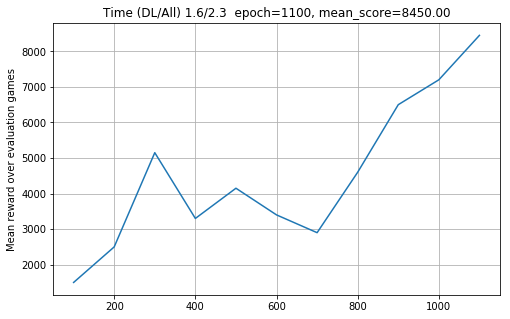

In [29]:
eval_and_plot(rewards, epoch_counter, pool, target_score, th_times, loop_times)

In [30]:
rewards

{100: 1500.0,
 200: 2500.0,
 300: 5150.0,
 400: 3300.0,
 500: 4150.0,
 600: 3400.0,
 700: 2900.0,
 800: 4600.0,
 900: 6500.0,
 1000: 7200.0,
 1100: 8450.0}

In [45]:
np.mean(pool.evaluate(n_games=1, record_video=False, verbose=False))

[2017-11-10 06:38:05,775] Making new env: KungFuMaster-v0
[2017-11-10 06:38:05,968] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-11-10 06:38:19,567] Finished writing results. You can upload them to the scoreboard via gym.upload('/notebooks/week7/records')


12800.0